In [4]:
#%matplotlib inline # comment out for Jupyter, leave in for Jupyterlab to get slider widget
import obspy
from obspy.io.segy.core import _read_segy
import numpy as np
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.signal import butter, lfilter, freqz, filtfilt, minimum_phase, welch
from scipy.signal import medfilt
from scipy.linalg import solve_toeplitz
from numpy.fft import fft, ifft, ifftshift


## load segy data

data loaded into 2D array, headers into separate 1D arrays, see obspy docs

see github.com/obspy/obspy/blob/master/obspy/io/segy/header.py#L53

In [221]:
def readsegy(inputfile, file_headers,DF_ASL, SrcElev, SRD_ASL):
    
    """ Load a segy file using obspy read_segy routine
        Number of traces can come from binary header or trace headers or
        the shape of the data file
        
        nrcv = section.stats.binary_file_header.number_of_data_traces_per_ens.
        can be useful if filled
        
        We use the matrix shape in this example to figure out the number of 
        traces and the number of samples per trace
        
        inputfile - segy file
        file_headers  - optionally print binary headers to terminal
        DF_ASL - drill floor elevation above Sea Level
        SrcElev - source elevation above sea level
        SRD_ASL - seismic reference datum above sea level
        
        Some useful headers are filled for velocity calculation
    """
    
    from obspy.io.segy.segy import _read_segy
    
    section = _read_segy(inputfile, unpack_headers = 'True')
    
    if (file_headers == 'y') or (file_headers == 'Y'):
    
        print (section.binary_file_header)
    
        x = np.array(list(section.textual_file_header.decode()))
        
        print('\n'.join(''.join(row) for row in x.reshape((40, 80))))
            
    data = np.vstack([d.data for d in section.traces])
    
    nrcv, samples = data.shape
  

    ####### get basic info from trace headers and save in 1d arrays #########      
    
    trnum, nsamp, srate, zscale = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                   np.empty((nrcv,1)),np.empty((nrcv,1)))

    zrcv, tsr, mdpth, tvddpth = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                   np.empty((nrcv,1)),np.empty((nrcv,1)))

    scalcoord, xsrc, ysrc, sdpth = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                   np.empty((nrcv,1)),np.empty((nrcv,1))) 

    xrcv, yrcv, auxtime_ms, ttime = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                   np.empty((nrcv,1)),np.empty((nrcv,1)))

    ttime_ms = (np.empty((nrcv,1)))

    n=0

    for tr in section.traces:
    
        trnum[n] = tr.header.trace_sequence_number_within_line
        nsamp[n] = tr.header.number_of_samples_in_this_trace
        srate[n] = tr.header.sample_interval_in_ms_for_this_trace
        zscale[n] = tr.header.scalar_to_be_applied_to_all_elevations_and_depths
        mdpth[n] = tr.header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group
        tvddpth[n] = tr.header.receiver_group_elevation
        scalcoord[n] = tr.header.scalar_to_be_applied_to_all_coordinates
        xsrc[n] = tr.header.source_coordinate_x/abs(scalcoord[n])
        ysrc[n] = tr.header.source_coordinate_y/abs(scalcoord[n])
        sdpth[n] = tr.header.source_depth_below_surface
        xrcv[n] = tr.header.group_coordinate_x/abs(scalcoord[n])
        yrcv[n] = tr.header.group_coordinate_y/abs(scalcoord[n])
        auxtime_ms[n]  = tr.header.lag_time_A          #trunc. to nearest ms
        ttime_ms[n]  = tr.header.lag_time_B            # trunc.to nearest ms
        ttime[n]  = tr.header.shotpoint_number/100     # divide if used
        n=n+1
    
    mdpth = mdpth/abs(zscale)
    
    tvddpth = tvddpth/abs(zscale)
    
    ############## shift elevations to reference datum ######################
    
    SrcZ = (sdpth *0) + SrcElev # careful, comment out if field is correct

    TVD_Src = tvddpth - (DF_ASL - SrcElev)
        
    TVD_SRD = tvddpth - (DF_ASL - SRD_ASL)
    
    SrcZ_SRD = SrcZ-SRD_ASL
    
    ############## make a file of trace headers #############################
    
    thead = np.hstack((trnum, mdpth, tvddpth,xrcv, yrcv,  xsrc, ysrc, sdpth, 
                       ttime,TVD_SRD, TVD_Src, SrcZ_SRD,auxtime_ms))
        
    ############## sort out sample rates ####################################
    
    numsamp = nsamp[0]
    samprate = srate[0]                    # sample interval in microseconds
    samprate_hz = 1000000/samprate
        
    tindex = np.zeros(shape = (data.shape[0], int(numsamp*(samprate/1000))))
    
    for k in range(0,data.shape[0]):
        tindex[k,:] = np.arange(0, numsamp*(samprate/1000) )  # samprate in ms
        
    ########### print some QC data to screen ################################

    print("\u0332".join('\nData Loading Stats :'))
    
    print (' data shape :', data.shape,' trace header  shape :', thead.shape)
    
    print (' data min max amplitude :', data.min(), data.max())
    
    print (' samples :', data.shape[1],' traces :', data.shape[0], ' ttime: ',\
           ttime.shape, ' fs samprate hz : ', samprate_hz, \
           'samprate microseconds : ', samprate, \
           '\n numsamp from headers : ', numsamp)
    
    print (' first time header value : ',ttime[0:1], \
           '\n first auxilliary time header value :', auxtime_ms[0:1])
    
    print (' source depth from header trace 1 :', sdpth[0:1])
    
    return data, numsamp, samprate, samprate_hz, tindex, thead

In [222]:
def write_segy(data, tracehead,fs, name):
    
    print("\u0332".join('\nWrite Segy Stats :'))
    
    print ('Data shape [0] :', data.shape[0],'Data shape [1] :', data.shape[1])
    
    print('Trace header shape', tracehead.shape)
    
    print ('time header :', tracehead[0:2,:])
    
    from obspy.core import read, Trace, AttribDict, Stream, UTCDateTime
    from obspy.io.segy.segy import SEGYBinaryFileHeader

    from obspy.io.segy.segy import SEGYTraceHeader
    from obspy.io.segy.segy import SEGYFile
    
    MD = tracehead[:,1].astype(int)
#    print ('MD shape :', MD.shape, ' MD dtype :' , MD.dtype)
    TVD = tracehead[:,2].astype(int)
    TVD = TVD.reshape(-1)
    RcvX = tracehead[:,3].astype(int)
    RcvY = tracehead[:,4].astype(int)
    SrcX = tracehead[:,5].astype(int)
    SrcY = tracehead[:,6].astype(int)
    SrcZ = tracehead[:,7].astype(int)
    TVD_SRD = tracehead[:,9].astype(int)
    TVD_Src = tracehead[:,10].astype(int)
    SrcZ_SRD = tracehead[:,11].astype(int)
    Tobs = (tracehead[:,8]*100).astype(int)
    IntV = tracehead[:,13].astype(int)
    
    print ('MD shape :', MD.shape, ' MD dtype :' , MD.dtype)
    
    stream = obspy.Stream()
    
    scalcoord = 10
    scaldep = 10
    
    for i, trace in enumerate(data):
    
        # Make the trace.
        tr = obspy.Trace(trace)
        
        tr.data = np.require(tr.data, dtype=np.float32)
 
        # Add required data.
        tr.stats.delta = 1/fs # fs is sample rate in hertz
        # tr.stats.starttime = 0  # Not strictly required.

        # Add yet more to the header (optional).
        tr.stats.segy = {'trace_header': SEGYTraceHeader()}
        tr.stats.segy.trace_header.trace_sequence_number_within_line = i + 1
        
        #for reference trhead = np.vstack([mdpth, tvddpth,xrcv, yrcv, xsrc, ysrc, sdpth, ttime])
          
        tr.stats.segy.trace_header.number_of_samples_in_this_trace = data.shape[1]
        tr.stats.segy.trace_header.sample_interval_in_ms_for_this_trace = (1/fs)*1000000
        tr.stats.segy.trace_header.scalar_to_be_applied_to_all_elevations_and_depths = scaldep*-1
        tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = \
                                int(MD[i]*scaldep)  
        tr.stats.segy.trace_header.receiver_group_elevation = int(TVD[i]*scaldep)
        tr.stats.segy.trace_header.scalar_to_be_applied_to_all_coordinates = scalcoord *-1
        tr.stats.segy.trace_header.source_coordinate_x = int(SrcX[i]*scalcoord)
        tr.stats.segy.trace_header.source_coordinate_y = int(SrcY[i]*scalcoord)
        tr.stats.segy.trace_header.source_depth_below_surface = int(SrcZ[i]*scaldep)
        tr.stats.segy.trace_header.group_coordinate_x = int(RcvX[i]*scalcoord)
        tr.stats.segy.trace_header.group_coordinate_y = int(RcvY[i]*scalcoord)
        tr.stats.segy.trace_header.lag_time_B = int(Tobs[i]/100)
        tr.stats.segy.trace_header.shotpoint_number = int(Tobs[i])
        tr.stats.segy.trace_header.transduction_units = int(IntV[i])
    
        # Append the trace to the stream.
        stream.append(tr)
        
    stream.stats = AttribDict()
    stream.stats.textual_file_header = b'C01 Synthetic Zero Offset VSP \n\
    C02 Median filtering tests\n\
    C03 VSProwess\n\
    C04\n\
    C05 WELL: Allan 1\n\
    C07 Processed by VSP Consultants\n\
    C08\n\
    C09 Reference Elevation:  ft\n\
    C10\n\
    C11 Geophone component: 025-028 Z=1, X=2, Y=3\n\
    C12 Source Easting:  073-076     Source Elev: 045-048\n\
    C13 Source Northing: 077-080\n\
    C14 Receiver Easting: 081-084    Measured Depth: 037-040\n\
    C15 Receiver Northing: 085-088   Vertical Depth: 041-044\n\
    C16\n\
    C17 Uncorrected Pick Time: 107-108\n\
    C18 TWO-Way Time : 109-110\n\
    C19\n\
    C20\n\
    C21 Units  = Survey Feet\n\
    C22 Wellhead Easting (ft): 0\n\
    C23 Wellhead Northing (ft): 0\n\
    C24\n\
    C25 ****Processing Steps: ***********\n\
    C26 Optimized Stack\n\
    C27 Median noise reduction\n\
    C28 Travel Times picked\n\
    C29\n\
    C30\n\
    C31\n\
    C32\n\
    C33\n\
    C34\n\
    C35\n\
    C36\n\
    C37\n\
    C38 VSProwess processing system\n\ '
    
    print (stream)

    stream.write('%s'%(name), format='SEGY', data_encoding=5)
    

## Import well information and time-depth

Time depth (measured) from trace header dump

Well deviation from field listing (already matched to receiver measured depth)

Correction of source and receiver to SRD depth

In [223]:
def importascii(DF_ASL, SrcElev, SRD_ASL, td_file, dev_file):
    
    """ 
    Used if deviation needs to be loaded. 
    Also useful if travel times are available in an ascii format
    
    """

    f = open(td_file, 'r')

    TD = np.genfromtxt(f, delimiter=',')
    TD = np.delete(TD,slice(0,2),0) # Erases the first 2 rows (i.e. the header)

    f2 = open(dev_file, 'r')

    WellData = np.genfromtxt(f2, delimiter=',')
    
    # take care of well deviation 
    # VSProwess does not apply deviaion if inc is < 5 degrees, so external deviation info may be required
    MD1 = TD[:,12]
    SrcX = TD[:,28] 
    SrcY = TD[:,29] 
    SrcZ = TD[:,30]
    Pick1 = TD[:,19] * 1000
    TVD = TD[:,13] 
    RecvX = TD[:,25]
    RecvY = TD[:,26]
    
    # this example uses an external deviation file from SLB field enginee
#    MD2 = WellData[:,0] 
#    TVD2 = WellData[:,3] 
#    RecvX = WellData[:,1]
#    RecvY = WellData[:,2]

    SrcZ = (SrcZ *0) + SrcElev # field headers were incorrect for this example, comment out if field is correct

    TVD_Src = TVD - (DF_ASL - SrcElev)
    TVD_SRD = TVD - (DF_ASL - SRD_ASL)
    SrcZ_SRD = SrcZ-SRD_ASL

    
    return RecvX, RecvY, TVD_SRD, TVD_Src, SrcX, SrcY, SrcZ_SRD, Pick1

    #DevData = np.delete(WellData,slice(0,2),0) # Erases the first 2 row (i.e. the header)

## Slice arrays by receiver number

remove rows above first receiver index

In [224]:
def depthlimit(VSPdata, headerfile, first, last):
    
    first = first - 1  #python indexing starts at 0, 
    last = last -1

    datanew = VSPdata[first:last,]
    
    headernew = headerfile[first:last,]
    print("\u0332".join('\nDepthlimit Stats :'))
    
    print(' data shape : ', VSPdata.shape)
    
    print (' headers shape :', headerfile.shape)
    
    print (' first :', first, ' last : ', last )
    
    print (' headers new shape :', headernew.shape)
        
    print(' data new shape : ', datanew.shape)
    
    return datanew, headernew


## Slice arrays to get a single receiver 

In [225]:
def chosetrace(VSP, thead, num):
    
    theadnew = thead[num:num+1,]

    datanew = VSP[num:num+1,]
    
    #print(datanew.shape)
    
    return datanew, theadnew


## Trace normalize data file

normalize by row (receiver) using Frobenius normalization. Can be changed to other norms.

Be careful with axis number, determines trace normalization or time normalization

stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose

In [226]:
def normalize (Seismic, norm, thead, scal):
    
    rdepth = thead[:,2]

#data normalization
#Frobenius norm is the default, L1 norm optional using data.sum
#row_sums = data.sum(axis=1)

    """ this method takes the whole trace, zeros before TT included so result 
    can be unexpected
    
    I need to create a method for normalizing in a window then apply 
    that norm factor to the whole trace
    """
    
    print("\u0332".join('\nNormalization Stats :'))
    
    data2 = np.zeros(shape = (Seismic.shape[0], Seismic.shape[1]))
    
    data1 = Seismic
    
    if (norm == 'Y') or (norm =='y'):
        
        row_sums = np.linalg.norm(data1, axis=1)
        
        print (' row_sums shape', row_sums.shape)
        
        data2 = (data1 / row_sums[:, np.newaxis])
        
        datascaled = data2 * scal
        
    else:
        
        datascaled = data1 * scal
        
    plt.figure(figsize=(15,7))
    
    ax1 = plt.subplot(111)
    
    ax1.plot(rdepth, row_sums, c = 'red')  # using fftfreq to get x axis
    
    ax1.set_title('Norm Factors') # %s at Depth %s'
                 # %(title_spec, zrcv_select))
    
    ax1.set_xlabel('TVD Depth')
    
    ax1.xaxis.grid()
    
    ax1.yaxis.grid()
    
    return datascaled


## Verticalize time

Standard straight ray correction

In [227]:
def VertTime(RecvX, RecvY, TVD_Src, SrcX, SrcY,SrcZ_SRD, RepVel, time):   
    
# calculate source-receiver offset
# verticalize the times relative to source elevation
# add in source to SRD time delay
    
    a=RecvX - SrcX
    b=RecvY - SrcY
    SROffset = np.sqrt(a**2+b**2)

    VertTT_Src = time * np.cos(np.arctan(SROffset/TVD_Src))
    VertTT_SRD = VertTT_Src - ((SrcZ_SRD)/RepVel)
    
#    print (time,VertTT_SRD)
    return VertTT_SRD 


## Velocity Calculations

Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to velocity array

Generate a version which is rounded and truncted for display as text

In [228]:
def velocities(VertTT_SRD, TVD_SRD, PTS):
    
    #calculate delta Depth and delta time arrays
    #interval velocity = depth/time 
    #calculate the first velocity and insert into velocity array
    
    from tabulate import tabulate


    T_Diff = np.ediff1d(VertTT_SRD/1000)
    D_Diff = np.ediff1d(TVD_SRD)
    firstTDiff = VertTT_SRD[0]/1000
    firstDDiff = TVD_SRD[0]
    TDiff = np.hstack((firstTDiff, T_Diff))
    DDiff = np.hstack((firstDDiff, D_Diff))

    IntVel = DDiff/TDiff

    FirstVel = TVD_SRD[0]/VertTT_SRD[0]
    DisplayVelRnd = np.rint(IntVel)             #round and convert to integer
    DisplayVelInt=DisplayVelRnd.astype(int)
    
    if (PTS == 'y') or (PTS == 'Y'):
    
        pdat = np.vstack((TVD_SRD, VertTT_SRD,TDiff, DDiff, IntVel)).T
    
        headers = ["Depth SRD", "Vert Time SRD", "Delta T", "Delta Z","Vp"]
    
        table = tabulate(pdat, headers, tablefmt="fancy_grid")

        print(table) 
    
    return IntVel, FirstVel, DisplayVelInt


In [229]:
def geovel(trheaders, repvel, PTS):
    
    # calculate source-receiver offset
    # verticalize the times relative to source elevation
    # add in source to SRD time delay
    
    from tabulate import tabulate
    
    print("\u0332".join('\nGeovel Stats :'))
    

    
    RcvX = trheaders[:,3]
    RcvY = trheaders[:,4]
    SrcX = trheaders[:,5]
    SrcY = trheaders[:,6]
    TVD_SRD = trheaders[:,9]
    TVD_Src = trheaders[:,10]
    SrcZ_SRD = trheaders[:,11]
    
    ttime = trheaders[:,8]
    
    a = RcvX - SrcX
    b = RcvY - SrcY
    
    SROffset = np.sqrt(a**2+b**2)

    VertTT_Src = ttime * np.cos(np.arctan(SROffset/TVD_Src))
    VertTT_SRD = VertTT_Src - ((SrcZ_SRD)/repvel)
    
#    print (time,VertTT_SRD)

    T_Diff = np.ediff1d(VertTT_SRD/1000)
    D_Diff = np.ediff1d(TVD_SRD)
    firstTDiff = VertTT_SRD[0]/1000
    firstDDiff = TVD_SRD[0]
    TDiff = np.hstack((firstTDiff, T_Diff))
    DDiff = np.hstack((firstDDiff, D_Diff))

    IntVel = DDiff/TDiff

    FirstVel = TVD_SRD[0]/VertTT_SRD[0]
    DisplayVelRnd = np.rint(IntVel)             #round and convert to integer
    DisplayVelInt=DisplayVelRnd.astype(int)
    
    IntVel = IntVel.reshape(-1,1)
    
    vheaders = np.hstack((trheaders, IntVel))
    
    IntVel = IntVel.reshape(-1,)
    
    print(' Theader shape', trheaders.shape, 'Vheader shape:', vheaders.shape)
    
    print (' TVD_SRD shape :', TVD_SRD.shape, ' IntVel shape :', IntVel.shape)
    
    print ('time header :', trheaders[0:2,:])
    
    print ('TVDSrc 2 vals  ',TVD_Src[0:2],'\nTVDSRD 2 vals ',TVD_SRD[0:2],
           '\nTTVert 2 vals  ', VertTT_SRD[0:2])
    
    
    if (PTS == 'y') or (PTS == 'Y'):
    
        pdat = np.vstack((TVD_SRD, VertTT_SRD,TDiff, DDiff, IntVel)).T
    
        headers = ["Depth SRD", "Vert Time SRD", "Delta T", "Delta Z","Vp"]
    
        table = tabulate(pdat, headers, tablefmt="fancy_grid")

        print(table) 
  
    return vheaders 


In [230]:
def header_listing(thead, listing):
    
    from tabulate import tabulate

    if listing == 'tz':
    
        pdat = thead[:,[8,1]]
    
        headers = [ "Observed Time", "Measured Depth",]
    
        table = tabulate(pdat, headers, tablefmt="fancy_grid")

        print(table) 

## Wiggle Plot

In [231]:
def wiggle_plot(thead, VSPdata, pol, Tmax, Tmin, first_rcv, spacing, skiplabel, 
                   numsamp, samprate, norm, scal, title_top):
    
    """Crossplot x (amplitude) and y (time). Add amplitude to receiver depth to 
    get trace deflection. Alternatively add amplitude to receiver number to get 
    trace deflection. Scaling in X direction (amplitude) is different in each 
    case

    """
    
    TVDSRD = thead[:,9]
    TT = thead[:,8]
    rcv_depth = thead[:,2]
    trace_num = thead[:,0]
    intVel = thead[:, 13]

    # trace deflection is based on sample value. Plots are spaced by receiver 
    # number or trace number. 
    # A scalar needs to be applied to make reasonable deflections, dependent 
    # on data amplitudes and plot spacing
    
    #T = widgets.IntSlider(value = 2500, min=2000, max=3000) # another day...
    
    #display(T)
    
    #Tmax = T.value
    
    numsamp = VSPdata.shape[1]
    
    first_rcv = first_rcv - 1 #python indexing starts at 0, 
    
    data2 = np.zeros(shape = (VSPdata.shape[0], VSPdata.shape[1]))
    
    data1 = VSPdata
    
    print("\u0332".join('\nWiggle Plot Global Information :'))
 
    print ('Number of traces in plot :', VSPdata.shape[0], 
           ' Number of samples per trace :', VSPdata.shape[1],
          ' first rcv :', first_rcv)

    if (norm == 'Y') or (norm =='y'):
        
        row_sums = np.linalg.norm(data1, axis=1)
        
        data2 = (data1 / row_sums[:, np.newaxis]) # problem for traces of all 0s
        
        datascaled = data2 * scal
        
    else:
        
        datascaled = data1 * scal
        
    if (pol == 'r') or (pol =='R'):
        
        datascaled = datascaled * -1
        
    print (' datascaled shape [0]',datascaled.shape[0], 
           ' datascaled shape [1]',datascaled.shape[1])
    
    fig = plt.figure(figsize=(25,20))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.2, 2], hspace = .05)
    
    ax1 = plt.subplot(gs[0])
    
    ax2 = plt.subplot(gs[1])
    
    skip =1 

    y = np.arange(0, numsamp*(samprate/1000), samprate/1000 )

    if (spacing == 'Z') or (spacing == 'z'):
        
        dscaler, pad = (rcv_depth, 10)
        
        dlabel = 'Receiver Depth'
        
    else:
    
        dscaler, pad = (trace_num, 1)
        
        dlabel = 'Receiver Number'
         
       # VSPdata = VSPdata/VSPdata.max()
    
    print ('np.min(TVDSRD) - pad', np.min(TVDSRD)-pad)
    
    print ('np.max(TVDSRD) + pad', np.max(TVDSRD)+pad)
        
    ax1.plot(TVDSRD, intVel, c='red',linewidth = .5, 
             label = 'Interval Velocity', drawstyle = 'steps-pre')

    ax1.set_xlim(np.min(TVDSRD)-pad, np.max(TVDSRD) + pad )
    
    ax1.set_title('Interval Velocity and %s'%(title_top),fontsize=14)
    
        
    for i, trace in enumerate(datascaled[::skip, :]):

        x = trace + dscaler[i]
    
        ax2.plot(x, y, 'k-', linewidth = .5)

        ax2.fill_betweenx(y, dscaler[i], x, where=(x > dscaler[i]), color='k')

        ax2.set_xlim(dscaler[0]-pad, dscaler[-1]+pad )

        ax2.set_ylim(Tmax, Tmin)

        ax2.set_xticks(dscaler[:-1:1])
        
        ax2.set_xlabel(dlabel)
   
    ax2.plot(dscaler,TT[0:],c='red',linewidth = 2, label = 'Travel Time' )
    
    for n, label in enumerate(ax2.xaxis.get_ticklabels()):
        label.set_rotation(90)
        if n % skiplabel != 0:
            label.set_visible(False)            
        
    ax2.yaxis.grid()
    
    plt.show()


In [232]:
def butter_bandpass(lowcut, highcut, fs, order, N):
    
    center = N//2  #seems important to keep spike at middle of window
    
    nyq = 0.5 * fs
    
    low = lowcut / nyq
    
    high = highcut / nyq
   
    b, a = butter(order, [low, high], btype='band')
    
    w, h = freqz(b, a, worN=2048)    # 2048 is subjective, more thought needed 
          
    ###################### get a discrete time impulse response ################
    
    x = np.zeros(N) 
    
    x[center] = 1 
    
    impulseresp = filtfilt(b,a, x)
    
    impulse_minphase = minimum_phase(impulseresp, method='hilbert')
    
    
    return b, a, impulseresp, w, h, impulse_minphase



In [233]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order, N):
    
    # https://stackoverflow.com/questions/12093594/how-to-implement-band-pass
    # -butterworth-filter-with-scipy-signal-butter
    
    #fs = sample rate in hz
      
    d, c,_,_,_,_ = butter_bandpass(lowcut, highcut, fs, order, N) # underbars 
                                                      # are throwaway variables

    y = filtfilt(d, c, data)
    
    return y

In [234]:
def plotbutt(fs, w, h, order, coeff, coeffmin,N):
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(211)
    
    plt.clf()
    
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    
    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    
    plt.xlabel('Frequency (Hz)')
    
    plt.ylabel('Gain')
    
    plt.grid(True)
    
    plt.legend(loc='best')
    
    plt.subplot(212)
    
    x = np.arange(0,N)                                 # N is number of samples 
    
    x2 = np.arange(0,N/2
                  )
    plt.scatter(x,coeff, c='red' )                      
    
    plt.scatter(x2,coeffmin, c='blue' )                
    
    plt.title('Butterworth Impulse Response',fontsize=14)
    
    plt.xlabel('Sample Number')


In [235]:
def shift(arr, tracehead, align, atime, fs):

    """ Shift VSP to align along direct arrival or to Two Way Time
   
    Adapted from from https://stackoverflow.com/questions/30399534/
                           shift-elements-in-a-numpy-array
    
    arr = VSP data array
    thead = header array to get xshift, the observed time header
    align = switch for alignment or shits to one-way or two-way time
    atime  = time to be aligned along 
    
    """
    xshift = tracehead[:,8]
    
    arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]))
    
    skip = 1
    
    xshift = xshift*(fs/1000)
    
    atime = int(atime *(fs/1000))
    
    print("\u0332".join('\nShifting Parameters :'))
    
    print ('fs :', fs,'\n', 'atime :', atime,'\n','first arr2 shape :', 
           arr2.shape)
           
    pad = arr.shape[1]-int(np.max(xshift))
                               
    if align == 'up':
        xshift = xshift.astype(int)
        arr = np.pad(arr, ((0,0),(0, pad)), 'constant')
        print ('pad : ', pad, 'arr shape :', arr.shape)
        
        arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]))
        
        print ('second arr2 shape :', arr2.shape)
               
    elif align == 'down':
        xshift = xshift - atime
        xshift = xshift.astype(int) * -1
    elif align == 'unalign':
        xshift = xshift.astype(int) - atime 

    for i, trace in enumerate(arr[::skip, :]):
        arr2[i,] = np.roll(arr[i,],xshift[i]) # carefulwith input array shape 
        if xshift[i] > 0:
            arr2[i,:xshift[i]] = 0 # [1, 4000] need row number 0
        elif xshift[i] < 0:
            arr2[i,xshift[i]:] = 0
            
    return arr2 


In [236]:
def mute(arr, thead, align):
    # methods from https://stackoverflow.com/questions/30399534/
    # shift-elements-in-a-numpy-array
    
    if align == 'owt':
        
        mute_time = thead[:,8] 
        
    elif align == 'twt':

        mute_time = thead[:,8]*2
    
    arr_mute = np.zeros(shape = (arr.shape[0], arr.shape[1])) 

    mtime = mute_time.astype(int)
   
    for k in range(0,(arr_mute.shape[0])):
        
        arr_mute[k,mtime[k]:-1] = arr[k,mtime[k]:-1]
            
    return arr_mute


In [237]:
def medfilt_along (x, k):
    
    # from https://gist.github.com/bhawkins/3535131
        
    """Apply a length-k median filter to a 1D array x.

    Boundaries are extended by repeating endpoints.

    """
    skip = 1

    out = x
    
    assert k % 2 == 1, "Median filter length must be odd."

#    assert x.ndim == 1, "Input must be one-dimensional."

    for b, trace in enumerate(x[::skip, :]):

        k2 = (k - 1) // 2
                
        y = np.zeros ((len (x[b,]), k), dtype=x.dtype)
        
        y[:,k2] = x[b,]
        
        row=b

        for i in range (k2):

            j = k2 - i

            y[j:,i] = x[row,:-j]

            y[:j,i] = x[row, 0]

            y[:-j,-(i+1)] = x[row,j:]

            y[-j:,-(i+1)] = x[row,-1]
            
        out[row,] = np.median(y, axis = 1)

    return out

In [238]:
def medfilt_across (x, k):
    
    # from https://gist.github.com/bhawkins/3535131
        
    """Apply a length-k median filter to a 1D array x.

    Boundaries are extended by repeating endpoints. at edge, input and output 
    
    traces are the same. 
    
    This can lead all zeros at edge traces after differencing.
    
    Traces with all zeros lead to division errors when trying to normalize

    """
    out  = np.zeros(shape = (x.shape[0], x.shape[1]))

    x = x.T
    
    assert k % 2 == 1, "Median filter length must be odd."

    for b, trace in enumerate(x[:, :]):

        k2 = (k - 1) // 2
                
        y = np.zeros ((len (x[b,]), k), dtype=x.dtype)

        y[:,k2] = x[b,]
        
        row=b
        
        for i in range (k2):

            j = k2 - i

            y[j:,i] = x[row,:-j]

            y[:j,i] = x[row, 0]

            y[:-j,-(i+1)] = x[row,j:]

            y[-j:,-(i+1)] = x[row,-1]
            
        out[:,row] = np.median(y, axis = 1)
        
    return out

In [239]:
def medfilt_across_scipy (x, k):
    
    """Apply a length-k median filter to a 1D array x.

    Boundaries are extended by repeating zeros. Seems to be better edge results
   
    see https://stackoverflow.com/questions/24585706/scipy-medfilt-wrong-result 

    """
   
    filt  = np.zeros(shape = (x.shape[0], x.shape[1]))

    x = x.T
    
    assert k % 2 == 1, "Median filter length must be odd."

    for b, trace in enumerate(x[:,:]):

        filt[:,b] = medfilt(x[b], k) #scipy median filter
        
    return filt

In [240]:
def diff(align1, align2):
    
    difference  = np.zeros(shape = (align1.shape[0], align1.shape[1]))
    
    difference = np.subtract(align1, align2)

    return difference

## Wiggle trace - single, sideways

Crossplot x (amplitude) and y (time). Add amplitude to receiver depth to get trace deflection. 

Alternatively add amplitude to receiver number to get trace deflection.



In [241]:
def plotsingletrace( VSP1, Tmin, Tmax, thead, spacing, scal1, title):
    
    rcv_depth = thead[0:1,2]

    trace_num = thead[0:1,0]
    
    data1scaled = VSP1 * scal1
        
    print("\u0332".join('\nSingle Trace Plot Global Information :'))
    
    print ('VSP1 shape :', VSP1.shape)
    print ('data1scaled shape :', data1scaled.shape)
 
    fig = plt.figure(figsize=(15,10))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], wspace = .25)
    
    ax1 = plt.subplot(gs[0])
    
    skip =1 

#    y = np.arange(0, numsamp*(samprate/1000) )
    y = np.arange(0, data1scaled.shape[0] )

    if (spacing == 'Z') or (spacing == 'z'):
        
        dscaler, pad = (rcv_depth, rcv_depth/10)
        
        dlabel = 'Receiver Depth'
        
    else:
    
        dscaler, pad = (trace_num, 2)
        
        dlabel = 'Receiver Number'

    x = data1scaled + dscaler
    
    xflat = x.ravel()
    

    print ('data1scaled shape [0] :', data1scaled.shape[0], 
           ' Number of samples per trace [1] :', data1scaled.shape[1])
    
    print (' x shape :', x.shape, ' x flat shape :', xflat.shape)
            
    
    ax1.plot(y, xflat, 'k-', linewidth = .5)

    ax1.fill_between(y, dscaler, xflat, where=(xflat> dscaler), color='k')
    
    ax1.set_ylim(dscaler-pad, dscaler+pad )

    ax1.set_xlim(Tmin, Tmax)

    ax1.set_yticks(dscaler[-1:1:]) #careful with the first and last
    
    ax1.set_ylabel(dlabel)
    
    ax1.set_title('%s'%(title), fontsize = 14)
   
    for label in ax1.yaxis.get_ticklabels():  
        label.set_rotation(90)
        
    ax1.xaxis.grid()
    
    plt.show()


In [242]:
def four_plots(VSP1, VSP2, VSP3, VSP4,fs, thead, scale, txt1, txt2, txt3, txt4):
    print("\u0332".join('\nWiggle Plot Global Information :'))
 

    rcvdepth = thead[:, 2]
    
    ################ create plot tick labeling and indexing ##############
    
    numsamp = VSP1.shape[1]

    tindex1 = np.arange(0, numsamp*(1000/fs),(1000/fs) )  # convert fs to msec.
    tindex2 = np.arange(0, VSP2.shape[1]*(1000/fs),(1000/fs))
    tindex3 = np.arange(0, VSP3.shape[1]*(1000/fs),(1000/fs))  
    tindex4 = np.arange(0, VSP4.shape[1]*(1000/fs),(1000/fs))
    
    rindex  = np.stack([rcvdepth for _ in range(VSP1.shape[0])], axis=1)

    print ('Number of traces in plot :', VSP1.shape[0], 
           ' Number of samples per trace :', ' tindex1 shape :,',tindex1.shape,
           ' tindex1 min max :', tindex1.min(),tindex1.max(),            
           ' tindex2 min max :', tindex2.min(),tindex1.max(), 
           ' tindex3 min max :', tindex3.min(),tindex1.max(), 
           ' tindex4 min max :', tindex4.min(),tindex1.max())
    
    ############### make plots of input and SVD filtered output ################
    
    fig = plt.figure(figsize=(20,7) )
    
    fig.subplots_adjust(wspace=0.125, hspace=0.5)
    
    ax1 = fig.add_subplot(141)    
    
    ax1.imshow(VSP1.T, cmap="gray", interpolation='none', 
               vmin = VSP1.min()/scale[0],vmax = VSP1.max()/scale[0],
               extent = [rindex.min(), rindex.max(), tindex1.max(), 
                tindex1.min()], aspect = 'auto')

    ax1.yaxis.grid()
    
    ax1.set_xlabel('Receiver Depth')
    
    ax1.set_title('%s'%(txt1))

    ax2 = fig.add_subplot(142)    
 
    ax2.imshow(VSP2.T, cmap="gray", interpolation='none',
               vmin = VSP2.min()/scale[1],vmax = VSP2.max()/scale[1],
               extent = [rindex.min(), rindex.max(), tindex2.max(), 
                tindex2.min()], aspect = 'auto')
    
    ax2.yaxis.grid()
    
    ax2.set_xlabel('Receiver Depth')
    
    ax2.set_title('%s '%(txt2))
    
#    ax2.set_yticklabels([])
    
    ax3 = fig.add_subplot(143)    
 
    ax3.imshow(VSP3.T, cmap="gray", interpolation='none',
               vmin = VSP3.min()/scale[2],vmax = VSP3.max()/scale[2],
               extent = [rindex.min(), rindex.max(), tindex3.max(), 
               tindex3.min()], aspect = 'auto')
    
    ax3.yaxis.grid()
    
    ax3.set_xlabel('Receiver Depth')
    
    ax3.set_title('%s '%(txt3))
    
#    ax3.set_yticklabels([])
        
    ax4 = fig.add_subplot(144)    
 
    ax4.imshow(VSP4.T, cmap="gray", interpolation='none',
               vmin = VSP4.min()/scale[3],vmax = VSP4.max()/scale[3],
               extent = [rindex.min(), rindex.max(), tindex4.max(), 
               tindex4.min()], aspect = 'auto')
    
    ax4.yaxis.grid()
    
    ax4.set_xlabel('Receiver Depth')
    
    ax4.set_title('%s '%(txt4))
    
#    ax4.set_yticklabels([])
    
    plt.show()

# Frequency Analysis

Plot input trace, plot windowed trace. Leading zeros needed to avoid tapering direct arrival

Do FFT of whole trace - including leading zeros

In [243]:
def FrAn(data, Tmax, Tmin,thead, trace, fs,spacing, norm, scale, title_spec):    

    import math 
    from math import ceil

    data_single, thead_single = chosetrace(data, thead, trace)
    
    TTobs_single = thead_single[:,8]
    zrcv_select = thead_single[:,2]
    trnum_single = thead_single[:,0]
    
    data_single = data_single.T
    
    print("\u0332".join('\nFrAn Parameters :'))
    
    print (' data single shape :',data_single.shape, ' TTobs shape :',
           TTobs_single.shape)
    
    print ('fs :', fs,)
    
    title = '%s at Depth %s Before Windowing'%(title_spec,zrcv_select)

    plotsingletrace(data_single, Tmax, Tmin, thead, spacing, scale, title)
    
    ####### window the trace to prevent edge effect in fft  #############
    
    dt =1/fs *1000   # sample rate in ms
    samprate = 1/fs        #sample rate in seconds

    
    win = 1024                              # ideally make window a power of 2 
                                                 


    start = (int(ceil(TTobs_single) / dt))  # include data from start - 
                                            # direct arrival - plus a window 
    stop = int(start + win/2)               # Divide window by 2 for VSProwess  
    
    data_single = data_single[0:stop]       # Apply window to whole trace so to
                                            # avoid tapering direct arrival
    N = data_single.size                         
        
#    w = np.blackman(N) # design a window 
#    w = np.kaiser(N,14) # design a window 
#    w = np.hamming(N) # design a window 
    w = np.hanning(N) # design a window
#    w = np.bartlett(N) # design a window
    
    data_single = data_single[:,0]*w        # Multiply trace by window
    
    data_for_plot = data_single.reshape(data_single.shape[0],-1) # shape [N,1] 
    
    title = '%s at Depth %s After Windowing'%(title_spec,zrcv_select)

    plotsingletrace(data_for_plot, Tmax, Tmin, thead, spacing, scale, title)
    
    ####### do the fft  #############
    
    X = np.fft.fft(data_single, n = N)      # from 0, to TT plus window
    
    X_db = 20*np.log10(np.abs(X)/np.max(np.abs(X)))# db=20*np.log10(S/np.max(S))
    
    freq = np.fft.fftfreq(N, d=samprate)    # Generate plot frequency axis 
    
    f = np.arange(0, N)*fs/N                # alternate method
                                                           
    ####### Only keep positive frequencies #########
    
    keep = freq>=0
    
    X = X[keep]
    
    X_db = X_db[keep]
    
    freq = freq[keep]
    
    f = f[keep]
    
    ####### Use Welch method to get spectra ########
    
    fw, psd = welch(data_single,
               fs,  # sample rate in hz
               window='hanning',   # apply a Hanning window before the DFT
               nperseg=512,        # periodograms of nperseg segments of x
               detrend='constant',
               scaling = 'spectrum', axis = 0 )
    
    psd_db = 20*np.log10(psd/np.max(psd))

    ############   make single trace plots   ################
    
    plt.figure(figsize=(15,15))
    
    ax1 = plt.subplot(211)
    
    ax1.plot(freq, np.absolute(X), c = 'red')  # using fftfreq to get x axis
    
    ax1.set_title('Amplitude Spectrum of %s at Depth %s'
                  %(title_spec, zrcv_select))
    
    ax1.set_xlabel('Frequency hz')
    
    ax1.set_xlim(0,200)
    
    ax1.xaxis.grid()
    
    ax1.yaxis.grid()

    ax2 = plt.subplot(212)
    
    ax2.plot(f,X_db, c='blue') #using number of samples and sample rate to get x axis
    
    ax2.set_title('Amplitude Spectrum in db of %s at Depth %s'
                  %(title_spec, zrcv_select))
    
    ax2.set_xlabel('Frequency hz')
    
    ax2.set_xlim(0,200)
    
    ax2.xaxis.grid()
    
    ax2.yaxis.grid()

    plt.show() 

## Main module

Adding sliders is tricky using Jupyter widgets, needed to update environment as in https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension

matplotlib widgets may be more general


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape : (240, 2500)  trace header  shape : (240, 13)
 data min max amplitude : -2.9418084e-09 4.129115e-09
 samples : 2500  traces : 240  ttime:  (240, 1)  fs samprate hz :  [1000.] samprate microseconds :  [1000.] 
 numsamp from headers :  [2500.]
 first time header value :  [[382.51]] 
 first auxilliary time header value : [[0.]]
 source depth from header trace 1 : [[100.]]

̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (240, 13) Vheader shape: (240, 14)
 TVD_SRD shape : (240,)  IntVel shape : (240,)
time header : [[ 1.0000e+00  3.0000e+03  3.0000e+03  0.0000e+00  0.0000e+00  5.0000e+01
   0.0000e+00  1.0000e+02  3.8251e+02  3.0000e+03  2.9900e+03 -1.0000e+01
   0.0000e+00]
 [ 2.0000e+00  3.0500e+03  3.0500e+03  0.0000e+00  0.0000e+00  5.0000e+01
   0.0000e+00  1.0000e+02  3.8730e+02  3.0500e+03  3.0400e+03 -1.0000e+01
   0.0000e+00]]
TVDSrc 2 vals   [2990. 3040.] 
TVDSRD 2 vals  [3000. 3050.] 
TTVert 2 vals   [382.45852887 387.24962522]


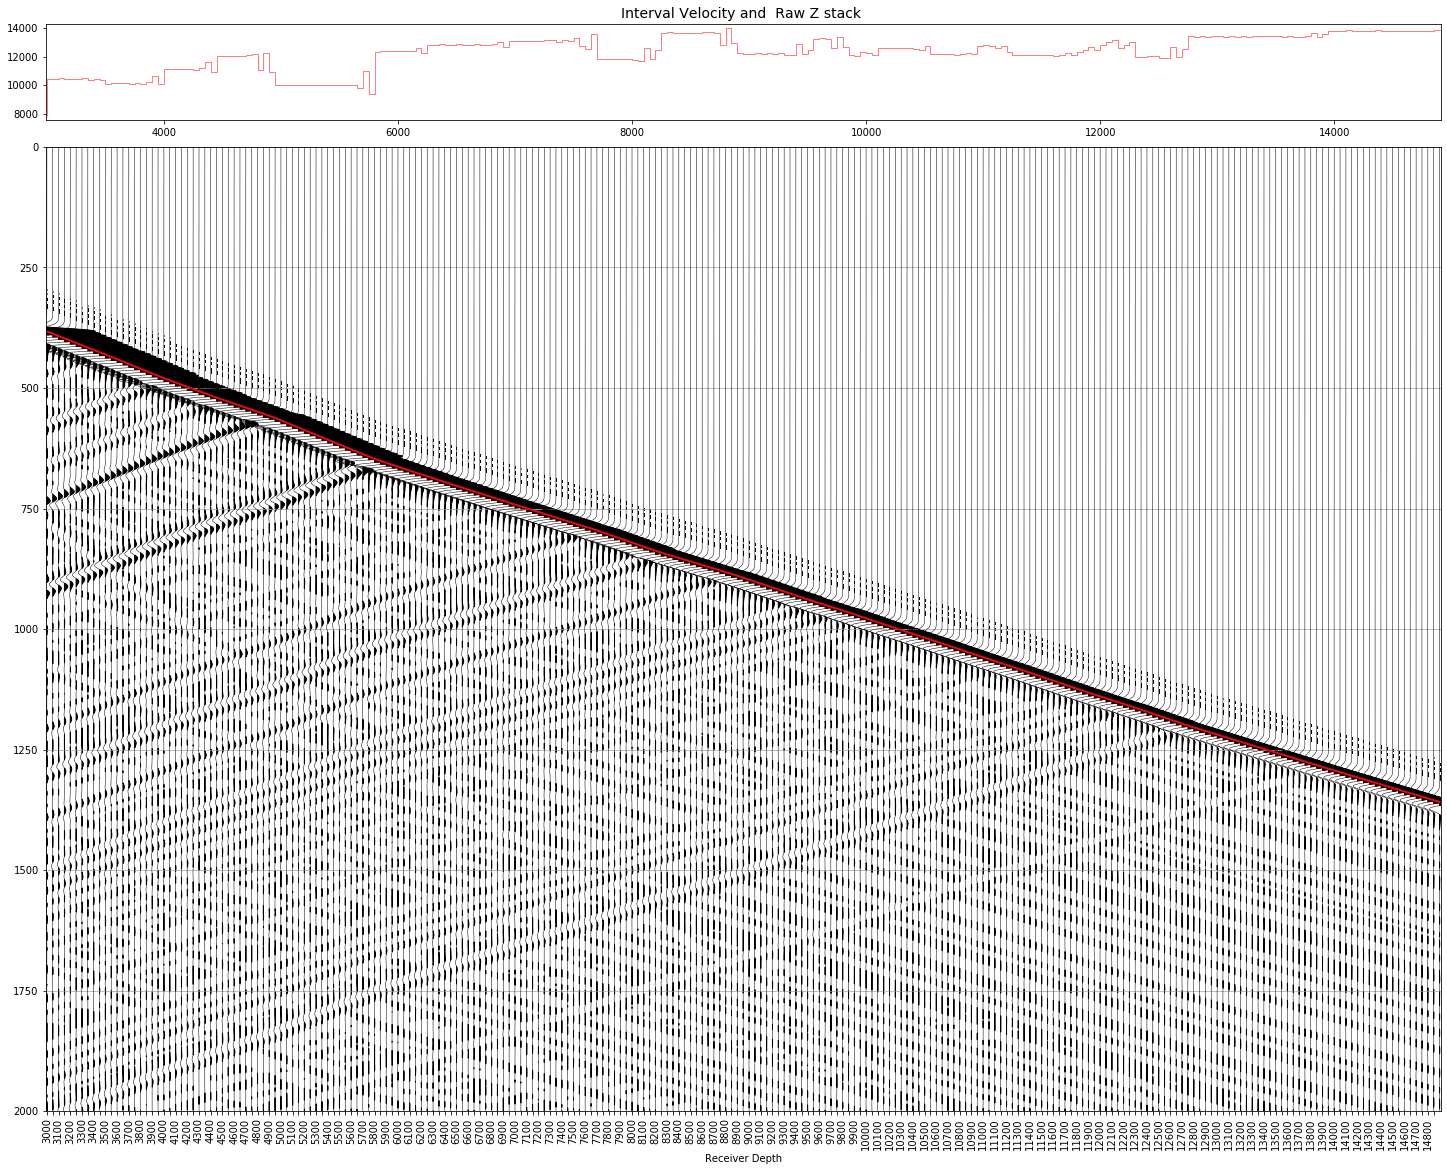


̲N̲o̲r̲m̲a̲l̲i̲z̲a̲t̲i̲o̲n̲ ̲S̲t̲a̲t̲s̲ ̲:
 row_sums shape (239,)

̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 239  Number of samples per trace : 2500  first rcv : 0
 datascaled shape [0] 239  datascaled shape [1] 2500
np.min(TVDSRD) - pad 2990.0
np.max(TVDSRD) + pad 14910.0


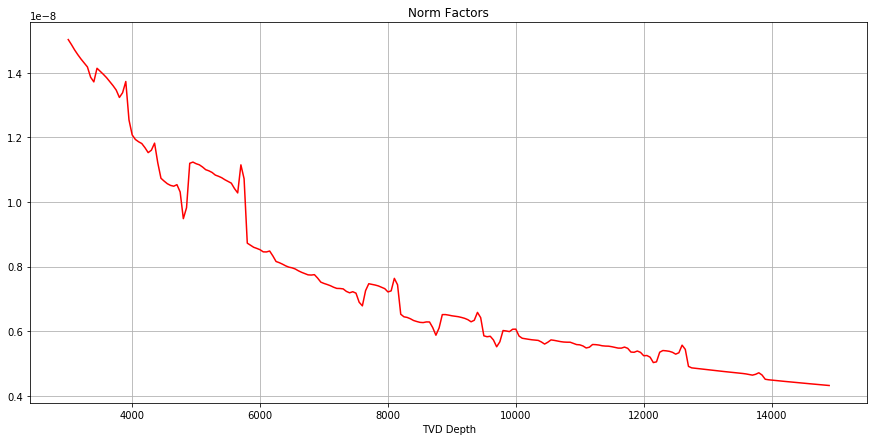

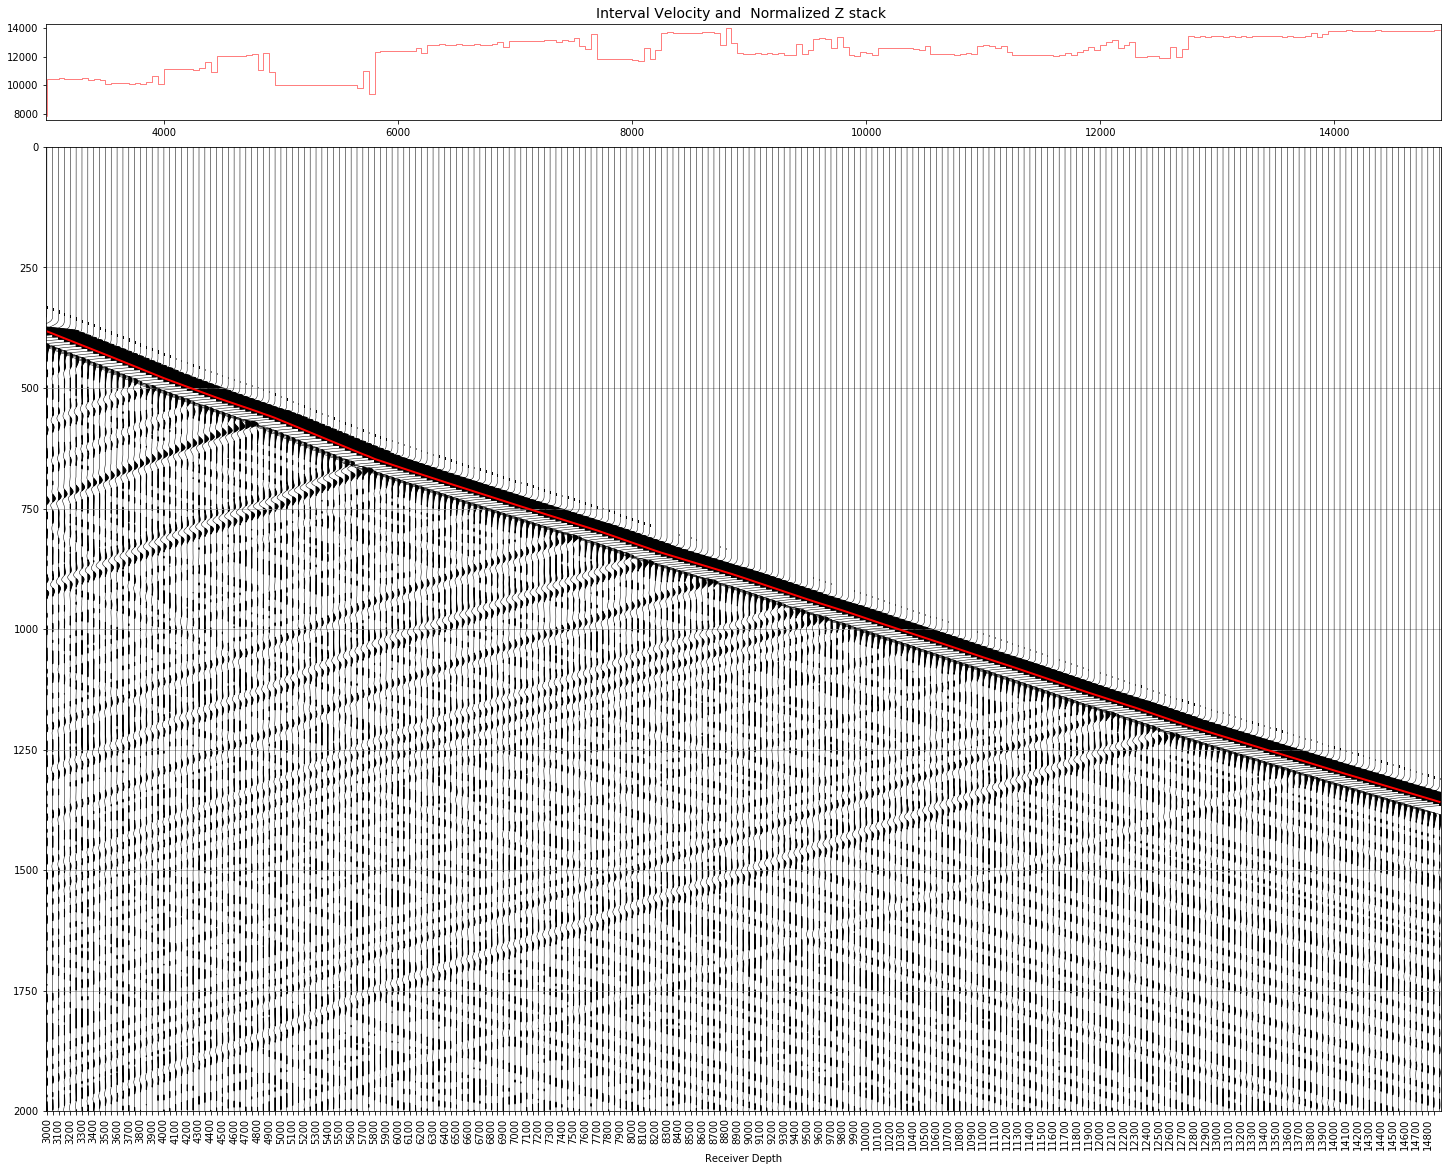


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 500 
 first arr2 shape : (239, 2500)

̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 500 
 first arr2 shape : (239, 2500)

̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 500 
 first arr2 shape : (239, 2500)
pad :  1142 arr shape : (239, 3642)
second arr2 shape : (239, 3642)

̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 239  Number of samples per trace : 3642  first rcv : 0
 datascaled shape [0] 239  datascaled shape [1] 3642
np.min(TVDSRD) - pad 2990.0
np.max(TVDSRD) + pad 14910.0


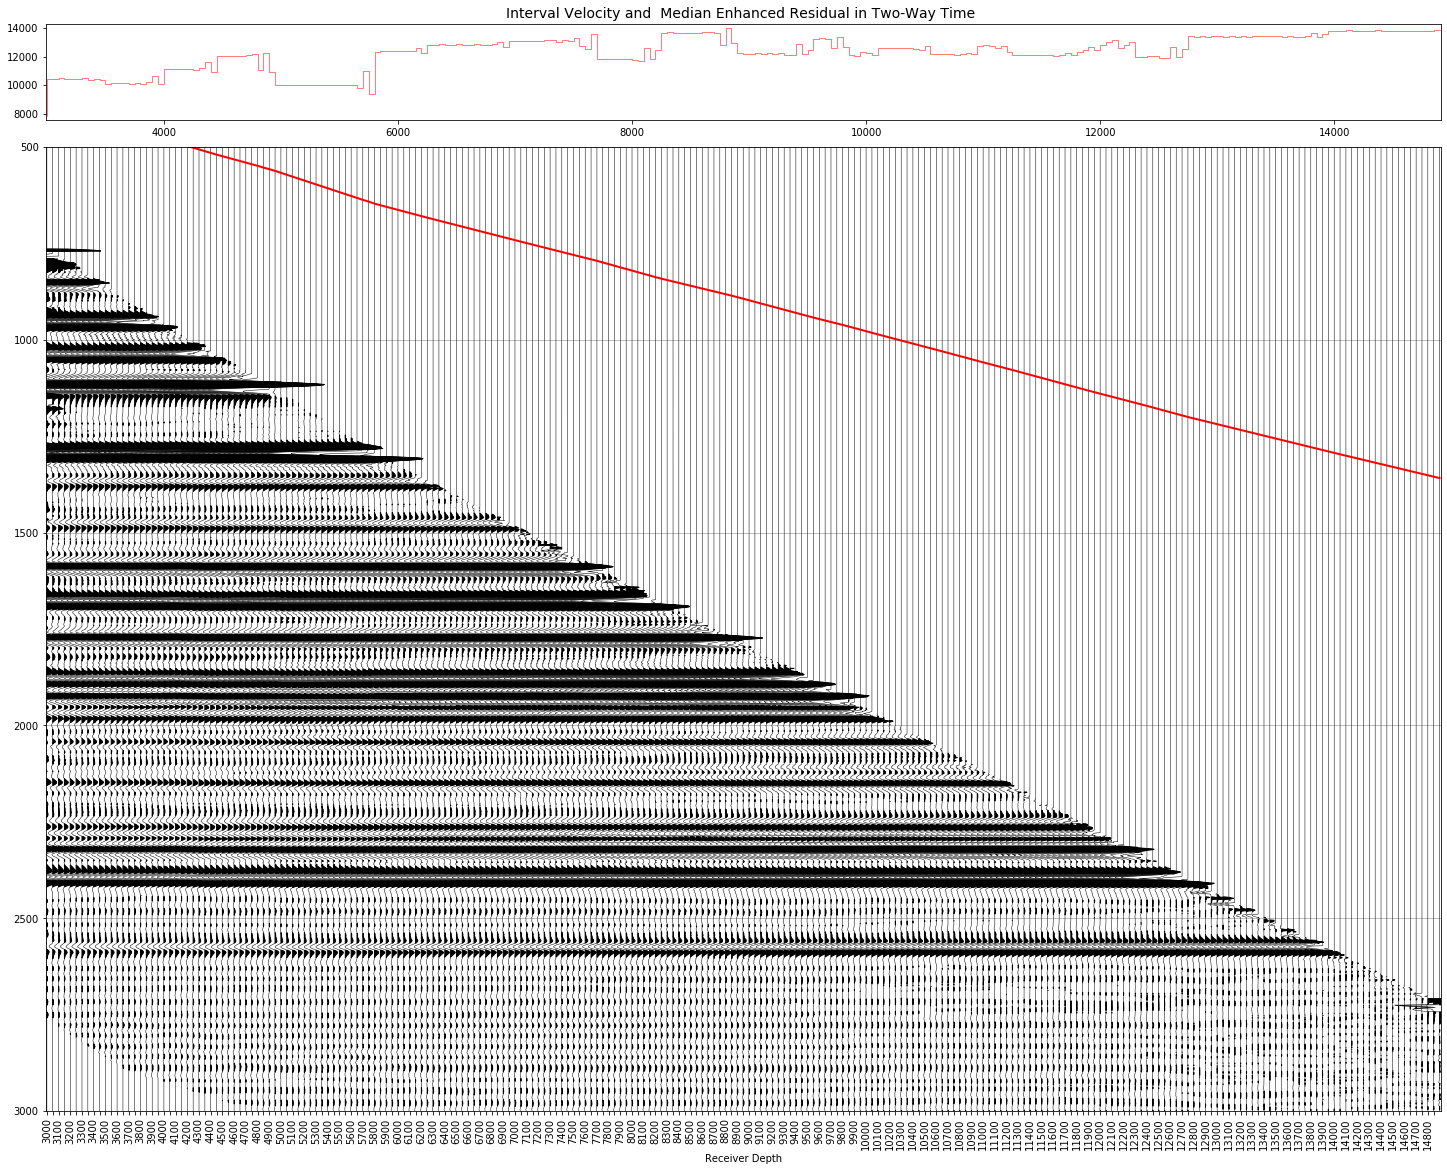


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 239  Number of samples per trace :  tindex1 shape :, (2500,)  tindex1 min max : 0.0 2499.0  tindex2 min max : 0.0 2499.0  tindex3 min max : 0.0 2499.0  tindex4 min max : 0.0 2499.0


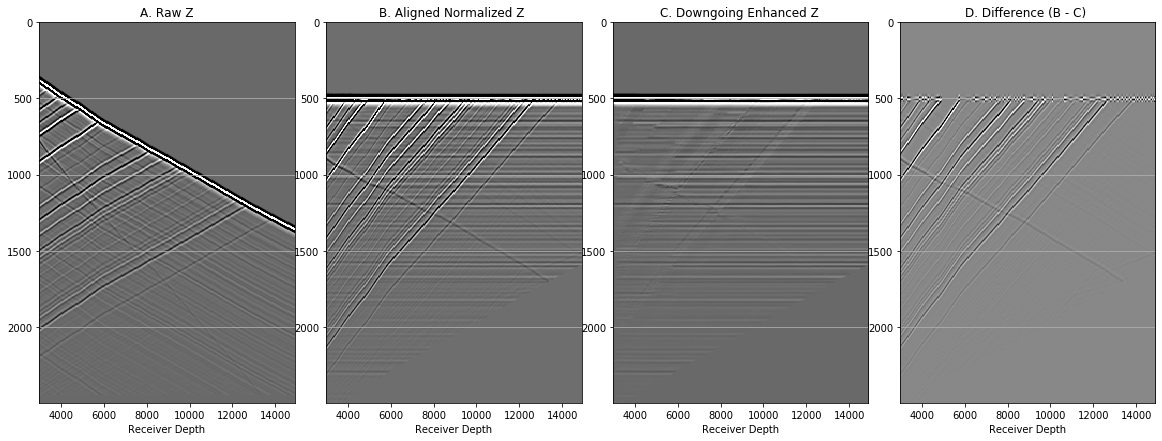


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 239  Number of samples per trace :  tindex1 shape :, (2500,)  tindex1 min max : 0.0 2499.0  tindex2 min max : 0.0 2499.0  tindex3 min max : 0.0 2499.0  tindex4 min max : 0.0 2499.0


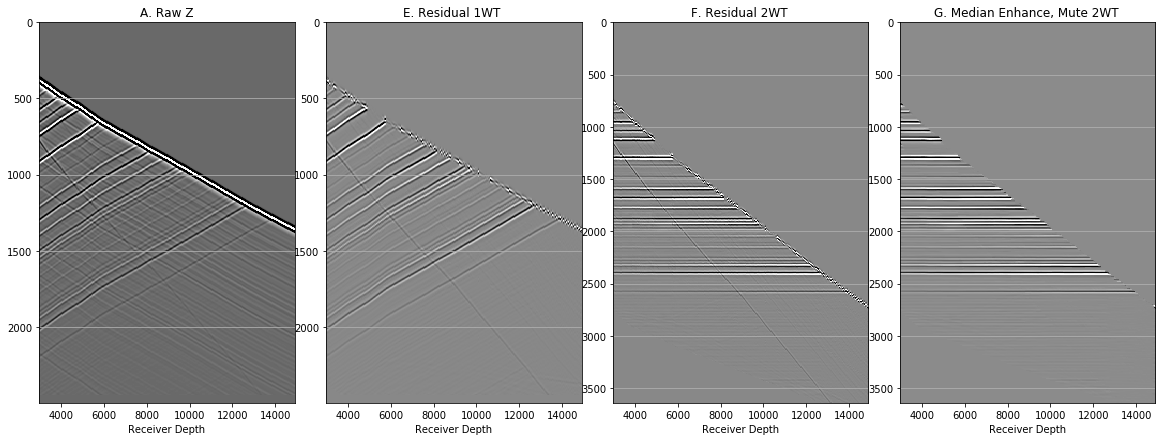


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data single shape : (2500, 1)  TTobs shape : (1,)
fs : [1000.]

̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (2500, 1)
data1scaled shape : (2500, 1)
data1scaled shape [0] : 2500  Number of samples per trace [1] : 1
 x shape : (2500, 1)  x flat shape : (2500,)


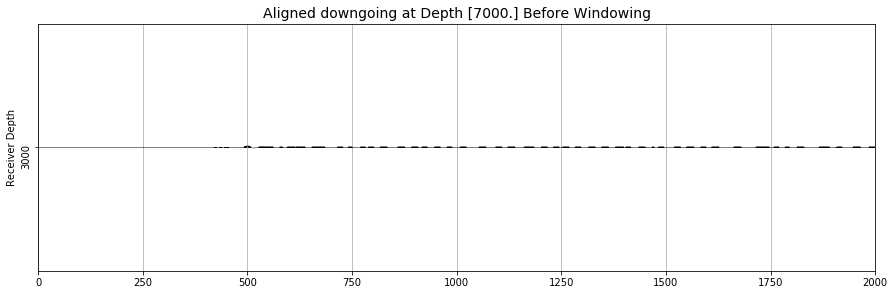


̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (1254, 1)
data1scaled shape : (1254, 1)
data1scaled shape [0] : 1254  Number of samples per trace [1] : 1
 x shape : (1254, 1)  x flat shape : (1254,)


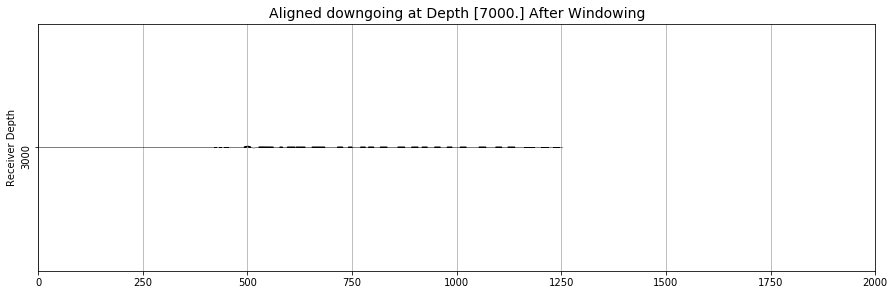

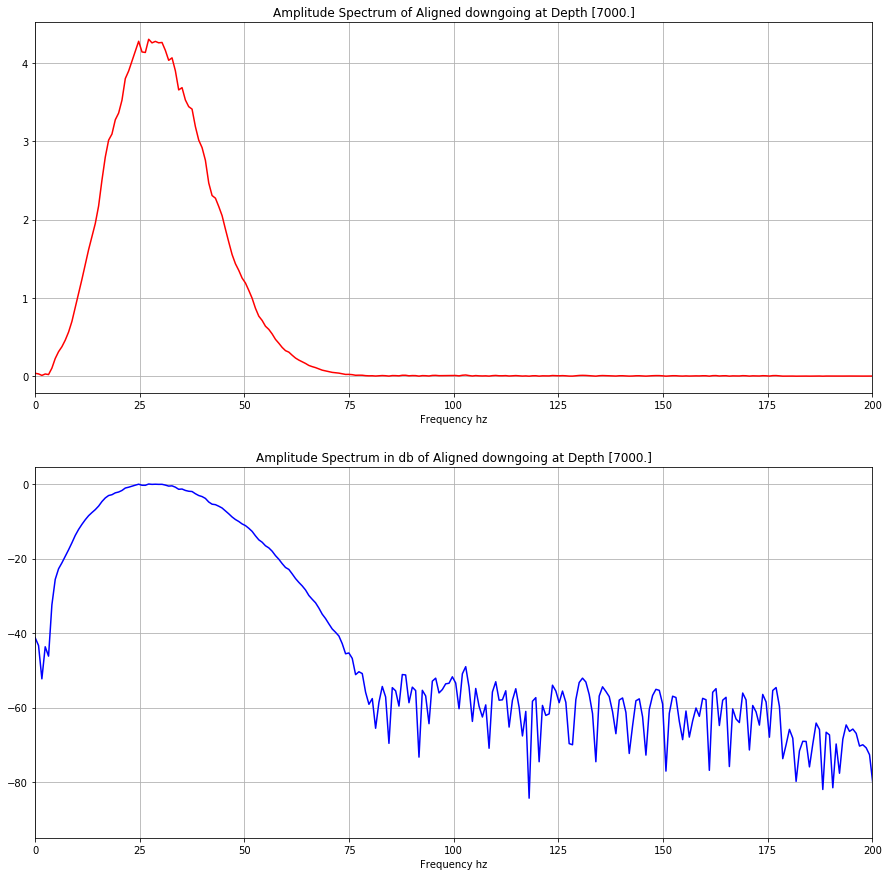

In [246]:
def main ():
    
   ############ get the data #########
    
    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
        '\\Synthetic_data\\data\\zvsp_fd_ms_12p5ft_grid_delayed.sgy')
    
    ############ input desired geometry parameters #########
    # VSP data
    
#    TDin = '..\data\db_0404_for_time_depth.csv' # time-depth file
#    
#    Devin = '..\data\dev_MD_TVD.csv' # well deviation
    
    ############ input desired geometry parameters #########
    
    RepVel= 5000     # replacement velocity
    SRD_ASL = 0    # SRD elevation above sea level
    DF_ASL = 0    # drill floor elevation ASL
    SrcElev = -10   # source elevation ASL


    ############ run basic loading functions ######### 
    
    file_head = 'n'         # print binary and text header to screen
    
    data, numsamp, samprate, fs, tindex,theader =  readsegy(
                      filename, file_head, DF_ASL, SrcElev, SRD_ASL)
    
    
    # samprate = sample rate in microseconds (1000microsec. = 1 ms)
    # fs = sample rate in hz (1ms = 1000 hz)
    
#    RecvX, RecvY, TVDSRD, TVDSrc, SrcX, SrcY, SrcZSRD, TTobs = importascii(
#                                       DF_ASL, SrcElev, SRD_ASL, TDin, Devin)

    ############ geometry corrections and velocity calculations #########
    
    table = 'n'
    
    vel_headers = geovel( theader, RepVel, table)
    
    ############ trim arrays if requested #########
    
    first_rcv =1
    last_rcv = 240
    
    data_edit, theader_edit = depthlimit(data,vel_headers, first_rcv, last_rcv)
    
    ############ first plot of wiggles and velocities #########
    
    Tmax, Tmin = 2000, 0

    hd_spacing = 2 # plot every nth header
    
    tr_spacing = 'z' # Z for traces spread by receiver depth
    
    plot_norm = 'n'         # trace norm = y
    
    plot_polarity = 'n'     # n for normal or tape polarity, r to flip polarity 
    
    Scalar = 100000000000   # check data sample values after read_segy
    
    Title_plot = ' Raw Z stack '
    
    wiggle_plot(theader_edit,data_edit, plot_polarity, Tmax, Tmin, first_rcv, 
                tr_spacing, hd_spacing, numsamp, samprate, plot_norm, Scalar, 
                Title_plot)
    
    ############  apply trace normalization if requested #########  
    
    Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm

    DScalar = 1             # usually 1, may be removed in future
    
    normed_edit = normalize(data_edit, Data_norm, theader_edit, DScalar)
    
    Scalar = 1000
     
    Title_plot = ' Normalized Z stack '

    wiggle_plot(theader_edit,normed_edit, plot_polarity, Tmax, Tmin, first_rcv, 
                tr_spacing, hd_spacing, numsamp, samprate, plot_norm, Scalar, 
                Title_plot)
        
    ######### Butterworth Wavelet design ##########
    
    # Sample rate and desired cutoff frequencies (in Hz).

    lowcut = 4
    highcut = 30

    order  = 3
    
    numfsamp = 512   # must be even   
   
    buttfilt = butter_bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                      numfsamp)
     
    ########### shifting traces #########
 
    updown = 'down' # down to align downgoing at aligntime, up to shift to TWT, 
                    # unalign to shift from aligned at aligntime to 1WT
    
    aligntime = 500 # align downgoing at 500ms
    
    alignedVSP = shift(normed_edit, theader_edit, updown, aligntime, fs)    
    
    Title_plot = ' Aligned and Normalized Z stack '
    
    ########### median filtering #########
    
    levels = 15
    
    aligndown_scipy = medfilt_across_scipy(alignedVSP, levels) # pad with zeros
    
#    Title_plot = ' Median Enhanced Aligned Downgoing '
    
    residual = diff(alignedVSP, aligndown_scipy)
    
#    Title_plot = 'Residual = Normalized Z stack - Aligned Upgoing '
    
    updown = 'unalign' 
    
    upwave1WT = shift(residual, theader_edit, updown, aligntime,fs)
    
#    Title_plot = ' Residual Shifted To One-Way Time '

    updown = 'up' 
    
    upwave2WT = shift(upwave1WT, theader_edit, updown, aligntime, fs)
    
    Tmax, Tmin = 3000, 500
    
#    Title_plot = ' Residual Shifted To Two-Way Time '
    
    levels = 9
    
    medianup2WT = medfilt_across(upwave2WT, levels)
    
    Title_plot = ' Median Enhanced Residual in Two-Way Time ' 

    tframe = 'twt' # owt or twt
    
    mute_medianup2WT = mute(medianup2WT, theader_edit, tframe)
    
    Scalar = 20000
    
    wiggle_plot(theader_edit,mute_medianup2WT, plot_polarity, Tmax, Tmin, first_rcv, 
                tr_spacing, hd_spacing, numsamp, samprate, plot_norm, Scalar, 
               Title_plot)

################# make thumbnail processing plots ##############################    
    
    ss_title1 = "A. Raw Z"
    
    ss_title2 = "B. Aligned Normalized Z"
    
    ss_title3 = "C. Downgoing Enhanced Z"
    
    ss_title4 = "D. Difference (B - C)"
    
    scalar = [20,20,20,2]             # scaling to plot 1,2,3,4 amplitudes
    
    four_plots(data_edit, alignedVSP, aligndown_scipy, residual, fs, 
               theader_edit, scalar, ss_title1, ss_title2, ss_title3, ss_title4)
    
    ss_title1 = "A. Raw Z"
    
    ss_title2 = "E. Residual 1WT"
    
    ss_title3 = "F. Residual 2WT"
    
    ss_title4 = "G. Median Enhance, Mute 2WT"
    
    scalar = [20,2,4,4]               # scaling to plot 1,2,3,4 amplitudes
    
    four_plots(data_edit,upwave1WT, upwave2WT, mute_medianup2WT, fs, 
               theader_edit, scalar, ss_title1, ss_title2, ss_title3, ss_title4)
     
    ###########  FRequency ANalysis    ########################################
    
    trace = 80
    
    stime, etime = 0, 2000
    
    spacing = 'z' # Z for traces spread by receiver depth
    
    norm = 'n'
    scale = 10
    
    title_fran = 'Aligned downgoing'
    
    FrAn(aligndown_scipy, stime, etime, theader_edit, trace, fs, spacing, 
         norm, scale, title_fran)
         
    '''   
    
    #################  output segy ############################################

    outfilename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
                  '\\Synthetic_data\\data\\residual_flat.sgy')
    
    outfilename2 = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
                  '\\Synthetic_data\\data\\down_flat.sgy')


    
    write_segy(residual, theader_edit, fs, outfilename)
    
    write_segy(aligndown_scipy, theader_edit, fs, outfilename2)
    ''' 
main()